In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import pdb
import GPyOpt

In [2]:
#データの読み込み
train_df = pd.read_csv("../dataset/train.csv")
test_df = pd.read_csv("../dataset/test.csv")
sub_df = pd.read_csv("../dataset/gender_submission.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(train_df)

891

## データの前処理

In [6]:
#trainデータの欠損値確認
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
#testデータの欠損値確認
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

(array([642., 182.,  40.,   1.,   6.,   7.,   1.,   1.,   2.,   1.,   1.,
          2.,   2.,   1.,   2.]),
 array([ 0.        ,  1.06666667,  2.13333333,  3.2       ,  4.26666667,
         5.33333333,  6.4       ,  7.46666667,  8.53333333,  9.6       ,
        10.66666667, 11.73333333, 12.8       , 13.86666667, 14.93333333,
        16.        ]),
 <a list of 15 Patch objects>)

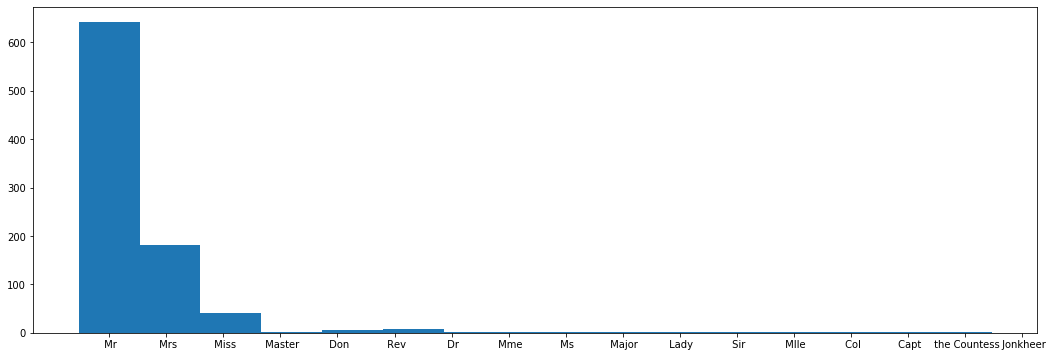

In [8]:
#train_dfの"Name"をいじる
title = [name.split(",")[1].split(".")[0] for name in train_df["Name"].tolist()]
plt.figure(figsize=(18,6))
plt.hist(title,align="left",bins=15)

In [9]:
set(title)

{' Capt',
 ' Col',
 ' Don',
 ' Dr',
 ' Jonkheer',
 ' Lady',
 ' Major',
 ' Master',
 ' Miss',
 ' Mlle',
 ' Mme',
 ' Mr',
 ' Mrs',
 ' Ms',
 ' Rev',
 ' Sir',
 ' the Countess'}

In [10]:
#各データセットで名前から特徴をとる
for i in range(len(title)):
    if title[i] in [' Don', ' Sir', ' Jonkheer',' the Countess', ' Lady', ' Dona']:
        title[i] = ' Noble'
    elif title[i] in [' Mlle', ' Ms']:
        title[i] = ' Miss'
    elif title[i] == ' Mme':
        title[i] = ' Mrs'
    elif title[i] in [' Capt', ' Col', ' Dr', ' Major', ' Rev']:
        title[i] = 'other'
train_df["title"] = title
title = [name.split(",")[1].split(".")[0] for name in test_df["Name"].tolist()]
for i in range(len(title)):
    if title[i] in [' Don', ' Sir', ' Jonkheer',' the Countess', ' Lady', ' Dona']:
        title[i] = ' Noble'
    elif title[i] in [' Mlle', ' Ms']:
        title[i] = ' Miss'
    elif title[i] == ' Mme':
        title[i] = ' Mrs'
    elif title[i] in [' Capt', ' Col', ' Dr', ' Major', ' Rev']:
        title[i] = 'other'
test_df["title"] = title

In [11]:
#それぞれの平均年齢を算出
train_df.groupby("title")["Age"].mean()

title
 Master     4.574167
 Miss      21.845638
 Mr        32.368090
 Mrs       35.788991
 Noble     41.600000
other      46.705882
Name: Age, dtype: float64

In [12]:
#年齢のnull値を先ほど算出した年齢で補間
train_df['Age'].fillna(train_df.groupby('title')['Age'].transform("mean"), inplace=True)
test_df['Age'].fillna(train_df.groupby('title')['Age'].transform("mean"), inplace=True)

In [13]:
train_df.loc[pd.isnull(train_df['Embarked'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


In [14]:
#Embarkedのnull値補間（2つだけ）
train_df.loc[61,'Embarked'] = 'S'
train_df.loc[829,'Embarked'] = 'S'

In [15]:
#Fareのnull値の補間（1つだけ）
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace = True)

In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [17]:
#質的変数のダミー変数化
cols = ["Survived","Age","SibSp","Parch","Fare","Pclass_2","Pclass_3","Sex_male","Embarked_Q","Embarked_S"]
X = pd.get_dummies(train_df,drop_first=True,columns=["Pclass","Sex","Embarked"])[cols]

cols_test = ["Age","SibSp","Parch","Fare","Pclass_2","Pclass_3","Sex_male","Embarked_Q","Embarked_S"]
test = pd.get_dummies(test_df,drop_first=True,columns=["Pclass","Sex","Embarked"])[cols_test]

In [18]:
X.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1


In [19]:
test.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,1,1,1,0
1,47.0,1,0,7.0000,0,1,0,0,1
2,62.0,0,0,9.6875,1,0,1,1,0
3,27.0,0,0,8.6625,0,1,1,0,1
4,22.0,1,1,12.2875,0,1,0,0,1


In [20]:
#"Age","SibSp","Parch","Fare"の数値を正規化に変換。
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X[["Age","Fare"]])
X[["Age","Fare"]] = scaler.transform(X[["Age","Fare"]])

scaler = preprocessing.StandardScaler()
scaler.fit(test[["Age","Fare"]])
test[["Age","Fare"]] = scaler.transform(test[["Age","Fare"]])

In [21]:
X.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,-0.584709,1,0,-0.502445,0,1,1,0,1
1,1,0.620760,1,0,0.786845,0,0,0,0,0
2,1,-0.283342,0,0,-0.488854,0,1,0,0,1
3,1,0.394734,1,0,0.420730,0,0,0,0,1
4,0,0.394734,0,0,-0.486337,0,1,1,0,1


In [22]:
test.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0.334394,0,0,-0.498407,0,1,1,1,0
1,1.298938,1,0,-0.513274,0,1,0,0,1
2,2.456391,0,0,-0.465088,1,0,1,1,0
3,-0.244332,0,0,-0.483466,0,1,1,0,1
4,-0.630150,1,1,-0.418471,0,1,0,0,1


## ニューラルネットワークの実装

In [23]:
data = X[["Age","SibSp","Parch","Fare","Pclass_2","Pclass_3","Sex_male","Embarked_Q","Embarked_S"]].values
target = X["Survived"].values

unit=1


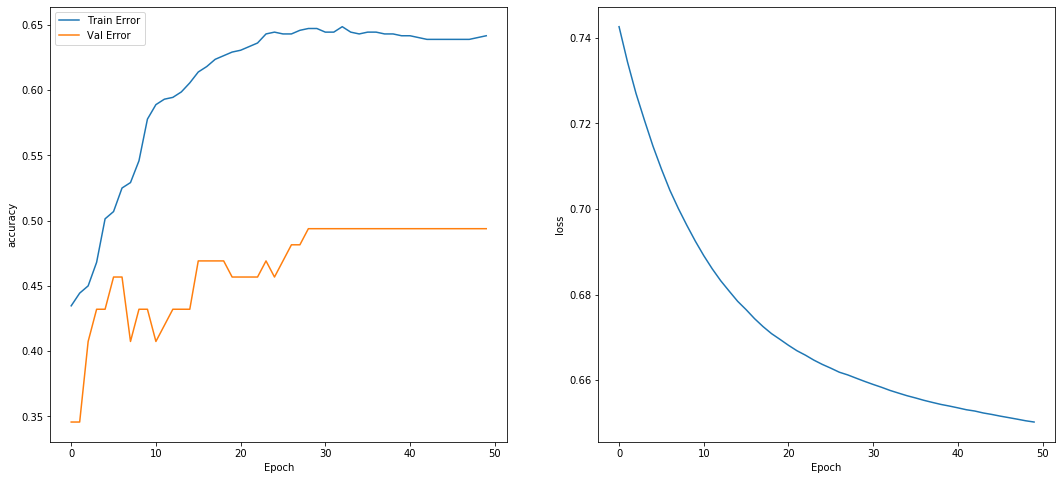

unit=2


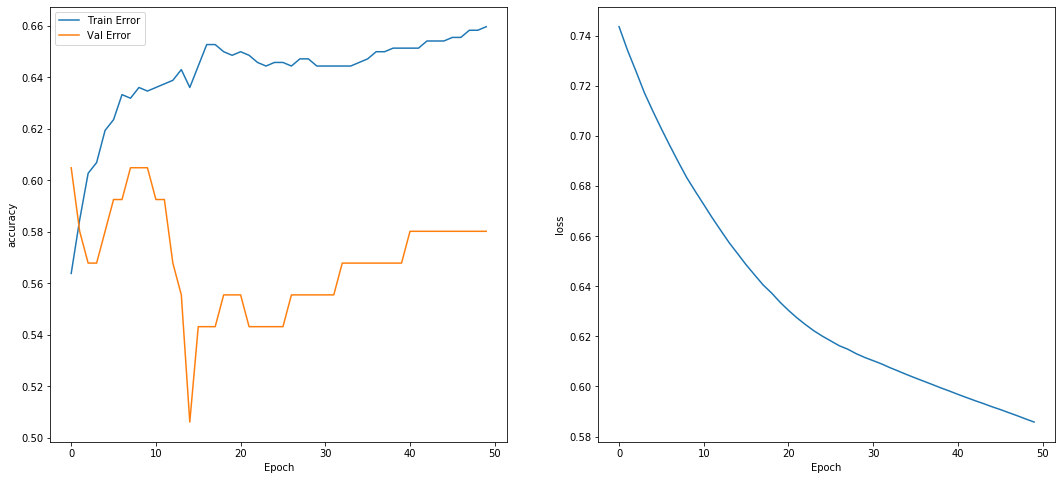

unit=3


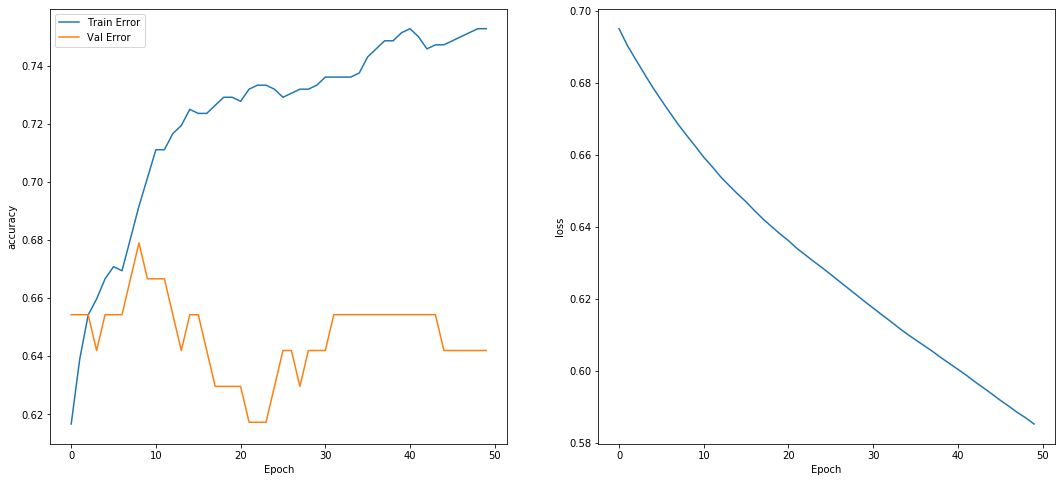

unit=4


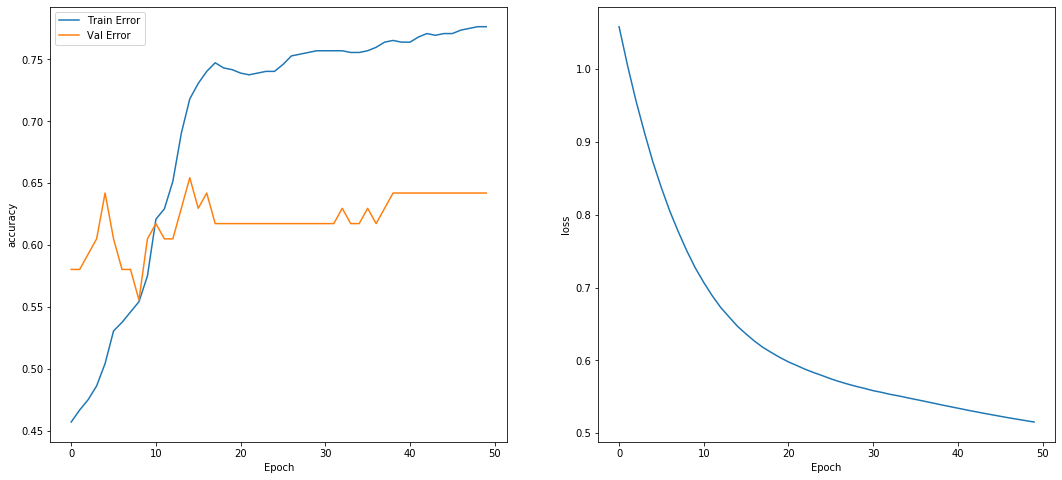

unit=5


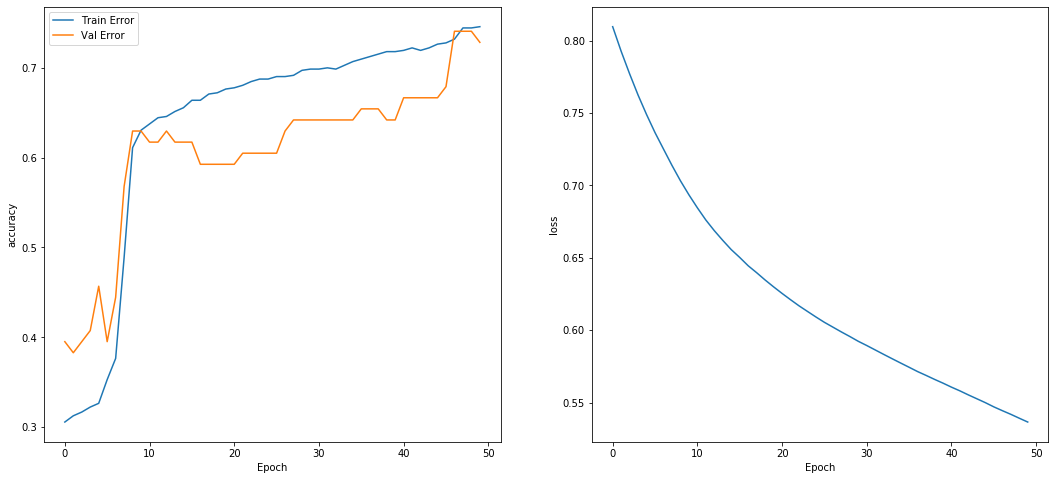

unit=6


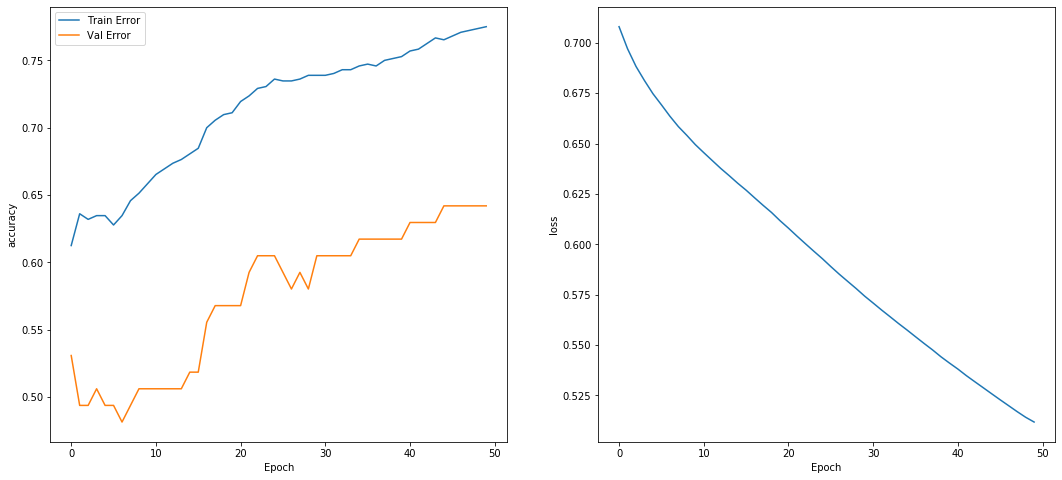

unit=7


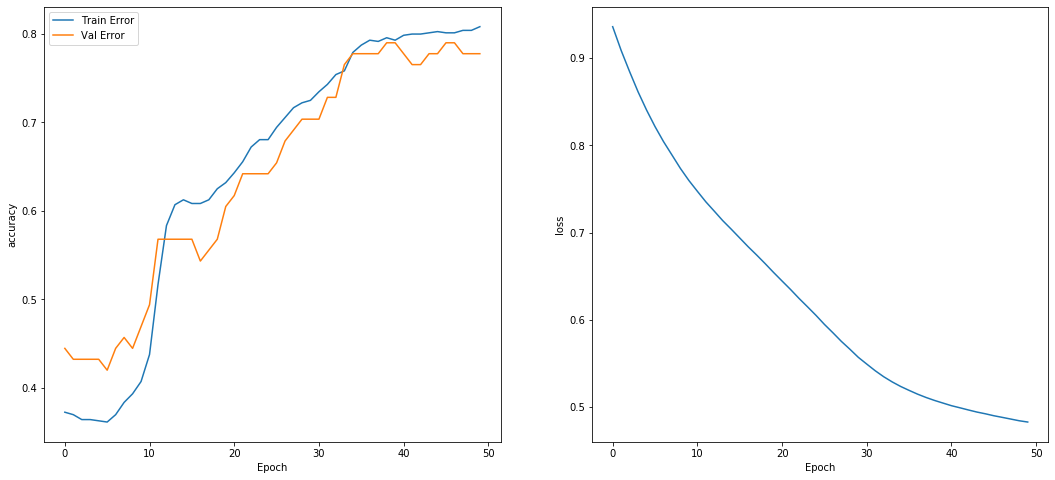

unit=8


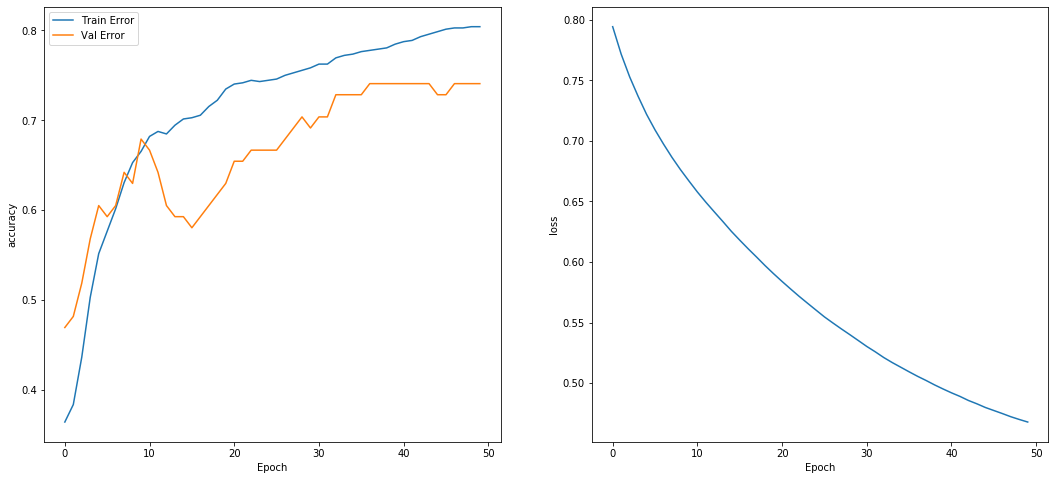

unit=9


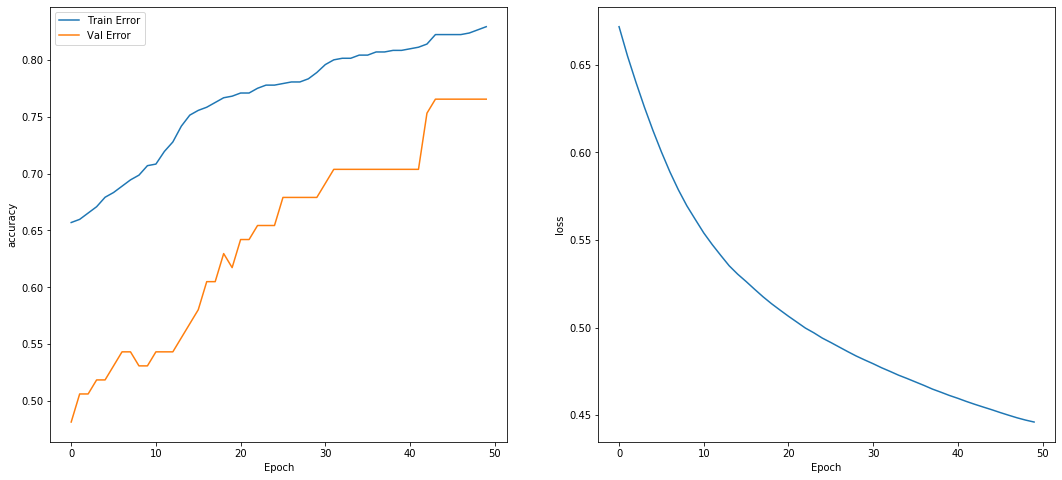

unit=10


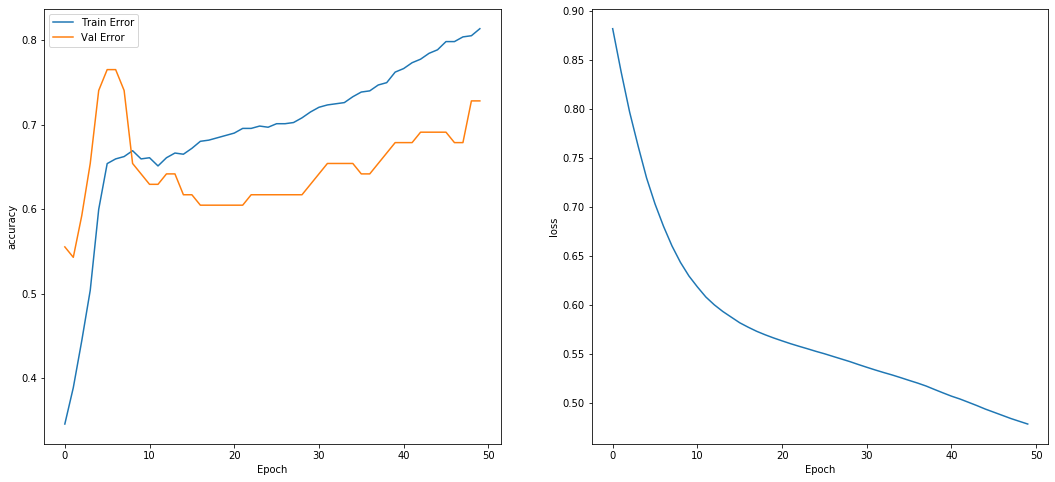

unit=11


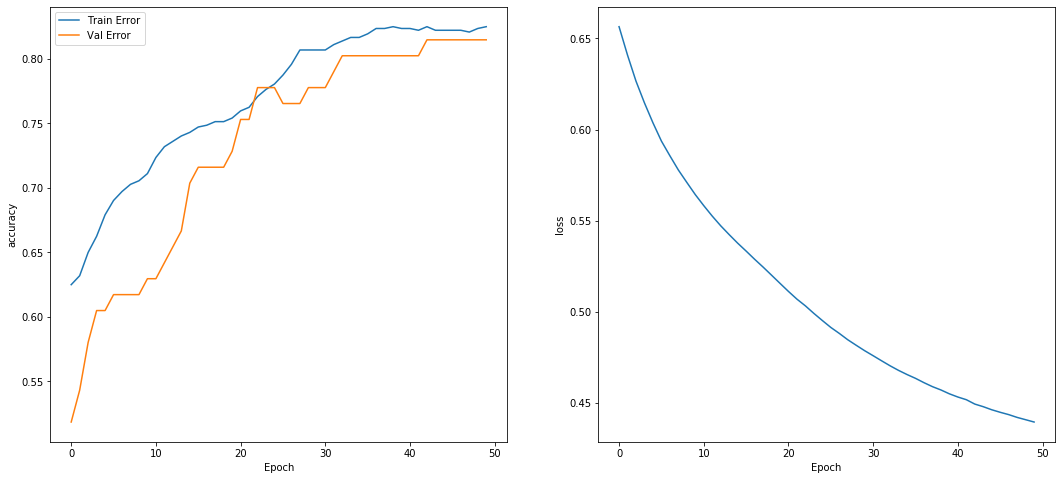

unit=12


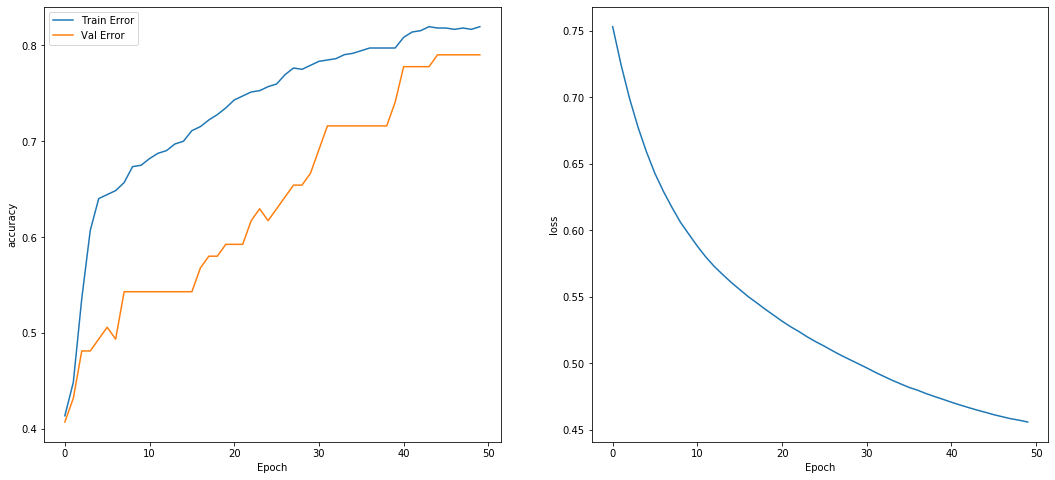

unit=13


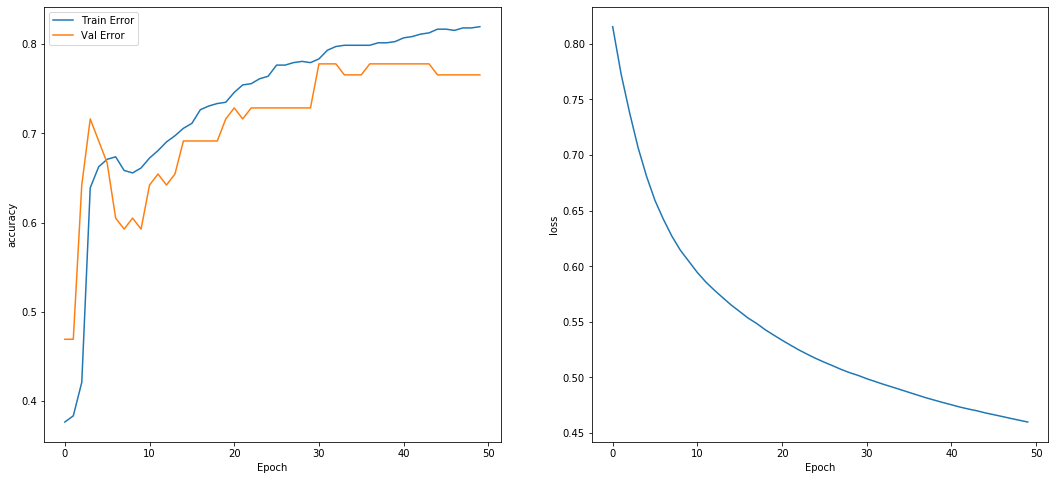

unit=14


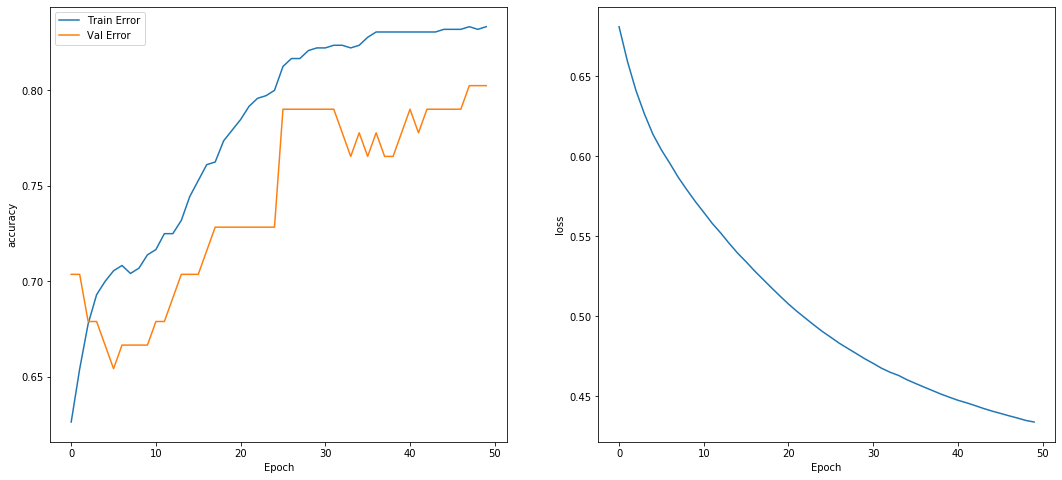

unit=15


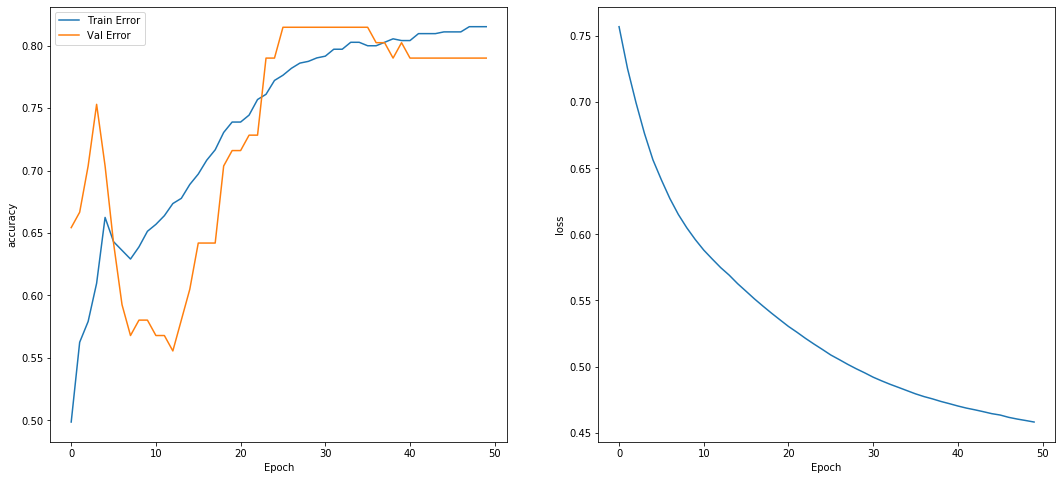

unit=16


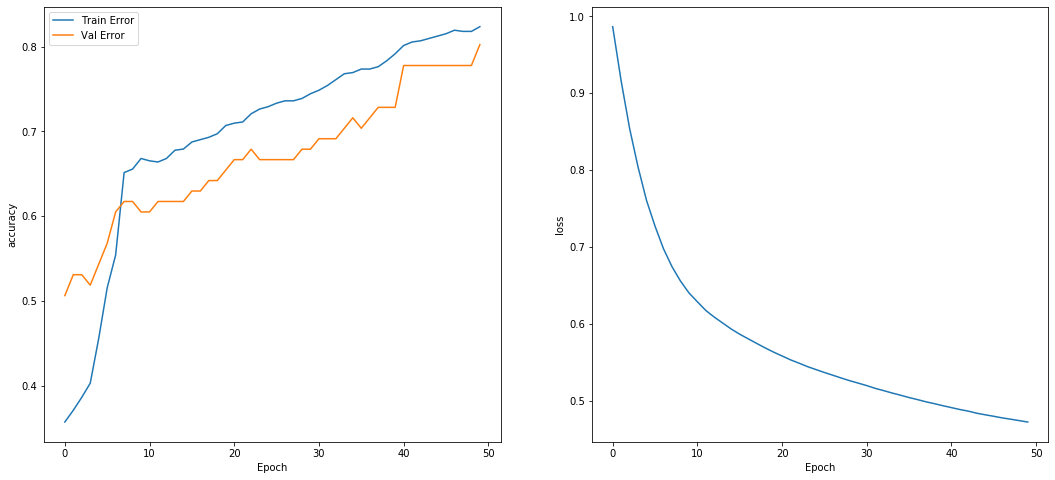

unit=17


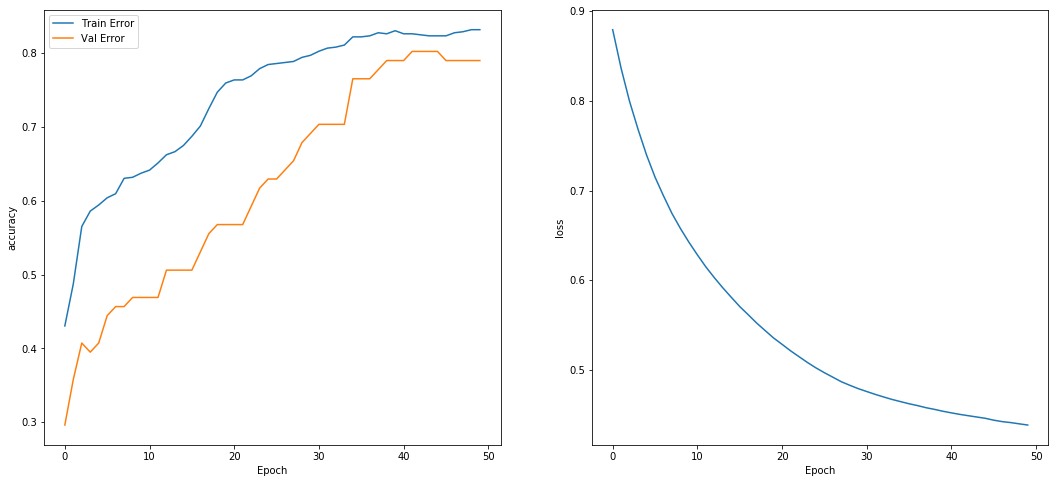

unit=18


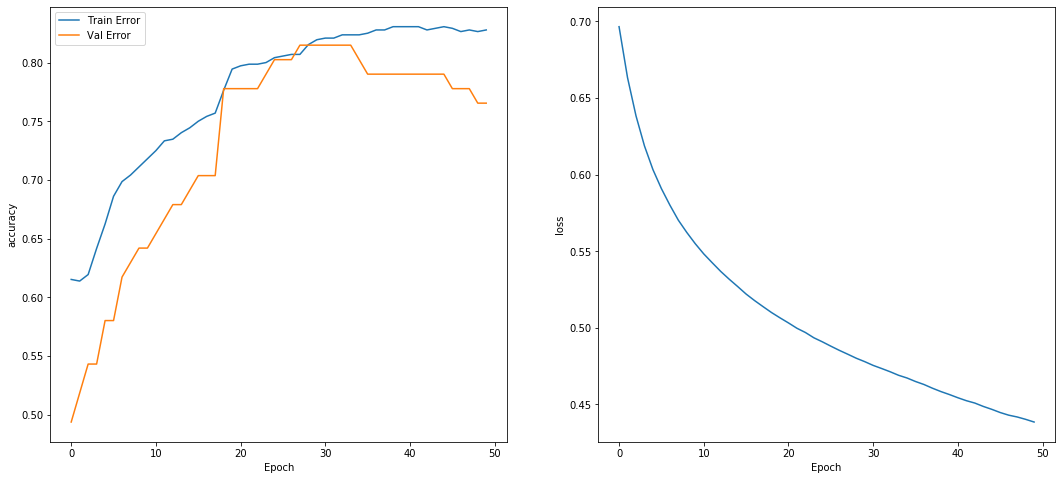

unit=19


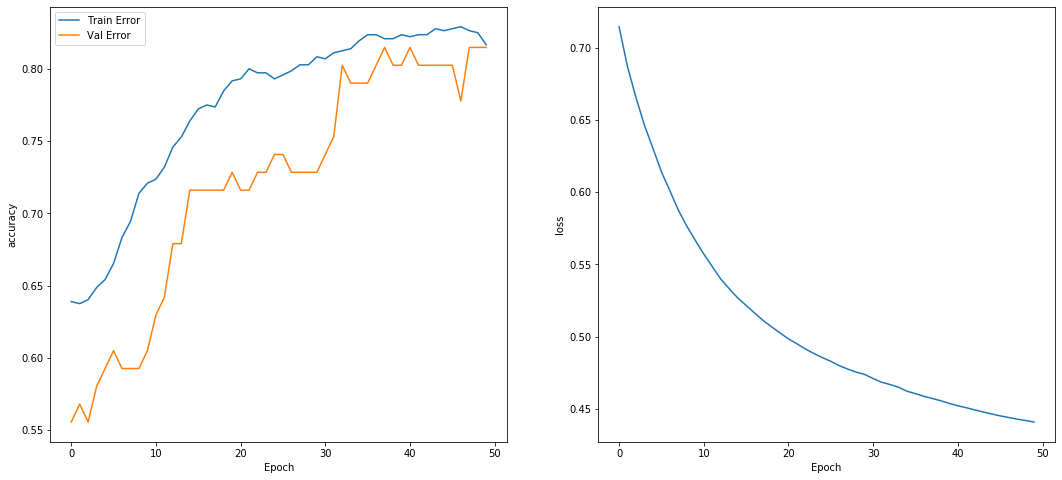

unit=20


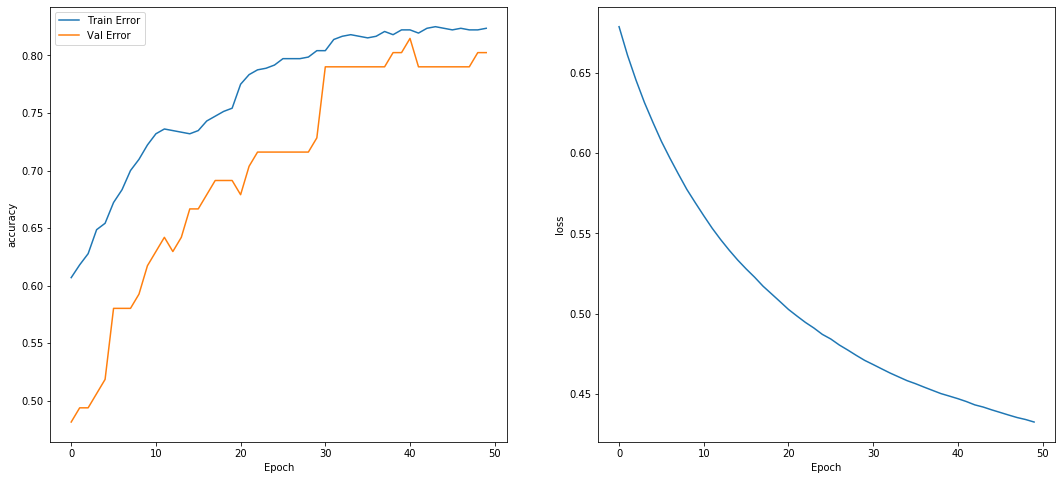

In [87]:
#中間層を１層としてノードの個数でfor文を回して変化をみる
x_train,y_train,x_test,y_test = model_selection.train_test_split(data,target,test_size=0.1,random_state=0)
for i in range(20):
    unit = i+1
    epoch = 50
    batch=100
    model = keras.Sequential([
        keras.layers.Dense(unit, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],)
    history = model.fit(x_train,x_test,batch_size=batch,epochs=epoch,validation_split = 0.1, verbose=0)

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    print("unit={}".format(unit))
    fig = plt.figure(figsize=(18,8))
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('accuracy')
    ax1.plot(hist['epoch'], hist['accuracy'],label='Train Error')
    ax1.plot(hist['epoch'], hist['val_accuracy'],label = 'Val Error')
    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('loss')
    ax2.plot(hist["epoch"],hist["loss"],label="loss")
    plt.show()

In [88]:
model.evaluate(y_train,y_test,batch_size=batch,verbose=0)

[0.4455828368663788, 0.75555557]

In [24]:
pred = model.predict(y_train).argmax(axis=1)
accuracy_score(y_test, pred)

0.7777777777777778

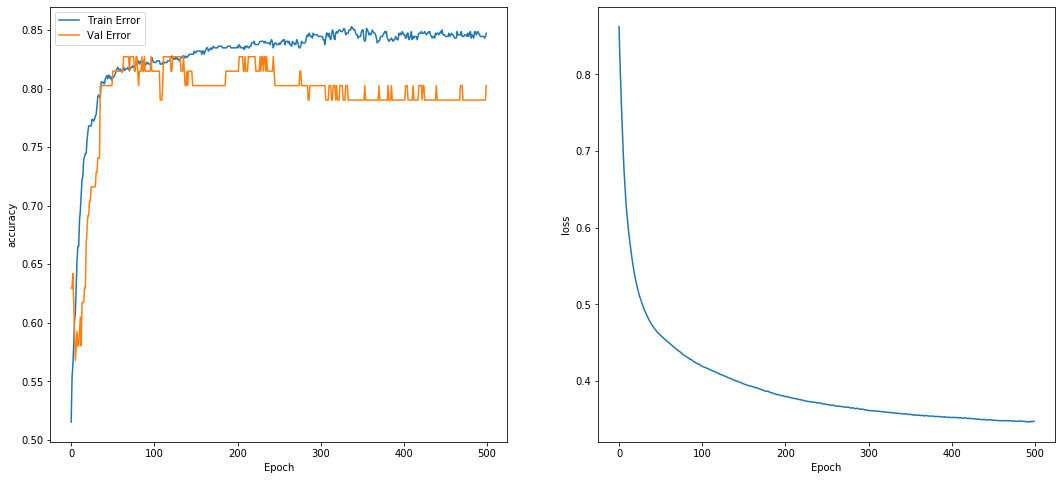

In [25]:
#中間層を２層にしてノード数 9,5とした。（なんとなく）
epoch = 500
model = keras.Sequential([
    keras.layers.Dense(9, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],)
history = model.fit(x_train,x_test,batch_size=batch,epochs=epoch,validation_split = 0.1, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

#print("unit={}".format(i+1))
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('accuracy')
ax1.plot(hist['epoch'], hist['accuracy'],label='Train Error')
ax1.plot(hist['epoch'], hist['val_accuracy'],label = 'Val Error')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('loss')
ax2.plot(hist["epoch"],hist["loss"],label="loss")
plt.show()

In [26]:
pred = model.predict(y_train).argmax(axis=1)
accuracy_score(y_test, pred)

0.8333333333333334

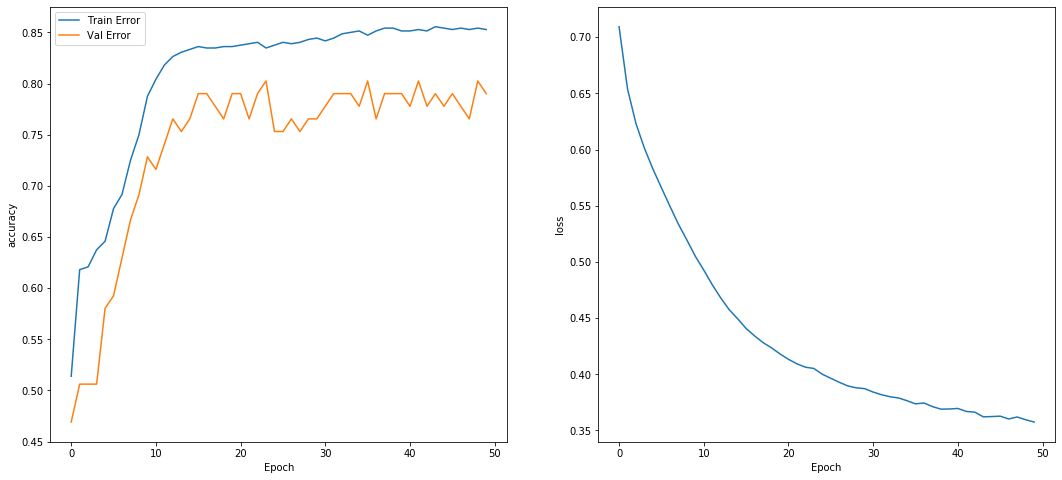

In [28]:
#中間層を３層にしてノード数も大きくしてみた
x_train,y_train,x_test,y_test = model_selection.train_test_split(data,target,test_size=0.1,random_state=0)
epoch = 50
model = keras.Sequential([
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],)
history = model.fit(x_train,x_test,batch_size=batch,epochs=epoch,validation_split = 0.1, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

#print("unit={}".format(i+1))
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('accuracy')
ax1.plot(hist['epoch'], hist['accuracy'],label='Train Error')
ax1.plot(hist['epoch'], hist['val_accuracy'],label = 'Val Error')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('loss')
ax2.plot(hist["epoch"],hist["loss"],label="loss")
plt.show()

In [29]:
pred = model.predict(y_train).argmax(axis=1)
accuracy_score(y_test, pred)

0.8222222222222222

In [81]:
pred_test = model.predict(test).argmax(axis=1)

In [84]:
sub_df["Survived"] = pred_test
sub_df.to_csv("../submit_csv/titnic_neural_network_submit.csv",index=False)

### ベイズ最適化

In [24]:
#dataの準備
data = X[["Age","SibSp","Parch","Fare","Pclass_2","Pclass_3","Sex_male","Embarked_Q","Embarked_S"]].values
target = X["Survived"].values
x_train,y_train,x_test,y_test = model_selection.train_test_split(data,target,test_size=0.1,random_state=0)

In [36]:
#ニューラルネットワークの構築と実装する関数
def neural(unit_1=10,unit_2=10,unit_3=10,batch_size=100,epoch=10):
    model = keras.Sequential([
        keras.layers.Dense(unit_1, activation='relu'),
        keras.layers.Dense(unit_2, activation='relu'),
        keras.layers.Dense(unit_3, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train,x_test,batch_size=batch_size,epochs=epoch,validation_split = 0.1, verbose=0)
    evaluation = model.evaluate(y_train,y_test,batch_size=batch_size,verbose=0)
    return evaluation

In [37]:
#ベイズ最適化用のパラメータの選択肢を作成
bounds = [{"name":"unit_1","type":"discrete","domain":(4,6,8,10,12,14,16,18,20)},
          {"name":"unit_2","type":"discrete","domain":(4,6,8,10,12,14,16,18,20)},
          {"name":"unit_2","type":"discrete","domain":(4,6,8,10,12,14,16,18,20)},
          {"name":"batch_size","type":"discrete","domain":(50,100,200)},
          {"name":"epoch","type":"discrete","domain":(5,10,20,30,40,50)}]

In [52]:
def f(x):
    evaluation = neural(unit_1=int(x[:,0]),unit_2=int(x[:,1]),unit_3=int(x[:,2]),batch_size=int(x[:,3]),epoch=int(x[:,4]))
    print("loss:{0} \t\t accuracy:{1}".format(evaluation[0], evaluation[1]))
    return evaluation[0]

In [53]:
opt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds)

loss:0.44544142484664917 		 accuracy:0.7666666507720947
loss:0.4766499400138855 		 accuracy:0.7666666507720947
loss:0.4414977861775292 		 accuracy:0.7888888716697693
loss:0.5733681321144104 		 accuracy:0.7111111283302307
loss:0.4680946403079563 		 accuracy:0.7555555701255798


In [54]:
opt.run_optimization(max_iter=30)
print("optimized parameters: {0}".format(opt.x_opt))
print("optimized loss: {0}".format(opt.fx_opt))

loss:0.40561529331737095 		 accuracy:0.800000011920929
loss:0.4466828140947554 		 accuracy:0.7666666507720947
optimized parameters: [ 8. 10. 18. 50. 30.]
optimized loss: 0.40561529331737095


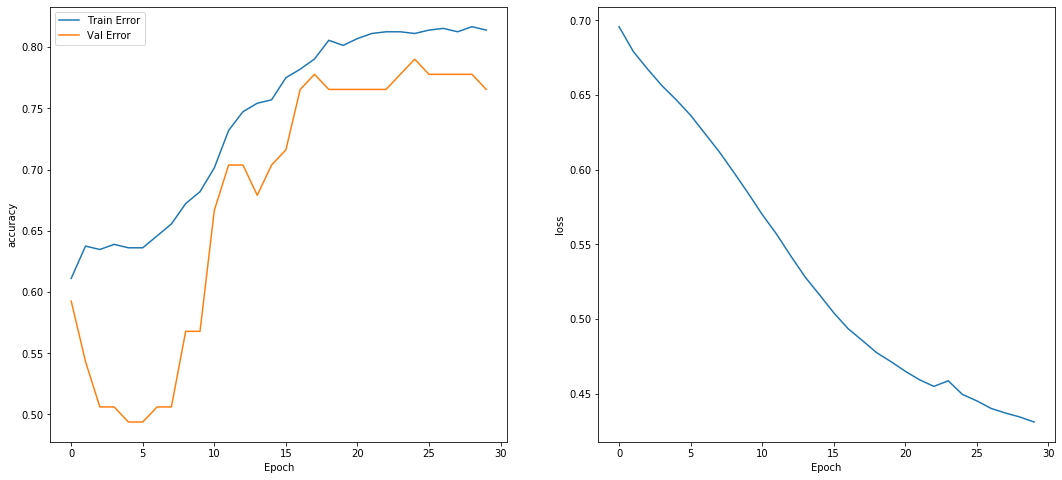

In [55]:
op_unit_1 = int(opt.x_opt[0])
op_unit_2 = int(opt.x_opt[1])
op_unit_3 = int(opt.x_opt[2])
op_batch_size = int(opt.x_opt[3])
op_epoch = int(opt.x_opt[4])
model = keras.Sequential([
        keras.layers.Dense(op_unit_1, activation='relu'),
        keras.layers.Dense(op_unit_2, activation='relu'),
        keras.layers.Dense(op_unit_3, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history = model.fit(x_train,x_test,batch_size=op_batch_size,epochs=op_epoch,validation_split = 0.1, verbose=0)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('accuracy')
ax1.plot(hist['epoch'], hist['accuracy'],label='Train Error')
ax1.plot(hist['epoch'], hist['val_accuracy'],label = 'Val Error')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('loss')
ax2.plot(hist["epoch"],hist["loss"],label="loss")
plt.show()

In [56]:
pred = model.predict(y_train).argmax(axis=1)
accuracy_score(y_test, pred)

0.7666666666666667

In [99]:
sub_pred = model.predict(test).argmax(axis=1)
sub_df["Survived"] = sub_pred
sub_df.to_csv("../submit_csv/titanic_neural_network_2.csv",index=False)

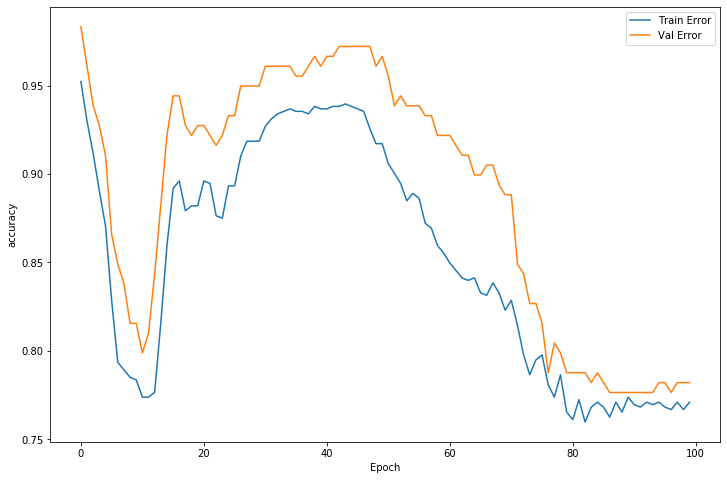

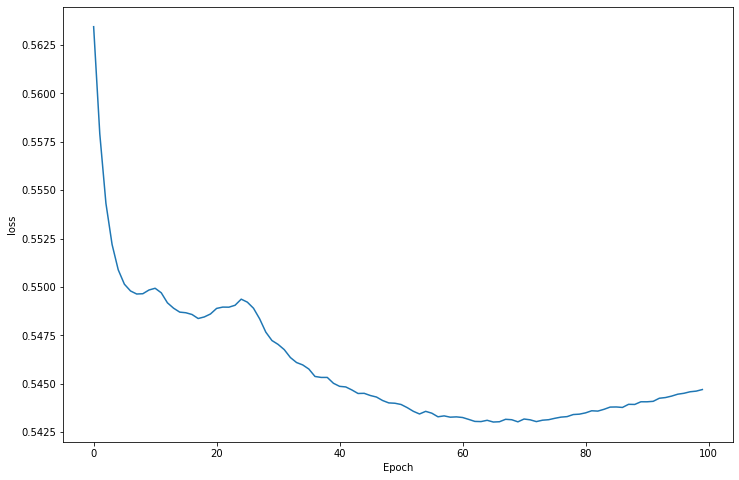

In [111]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.xlabel('Epoch')
ax1.ylabel('accuracy')
ax1.plot(hist['epoch'], hist['accuracy'],label='Train Error')
ax1.plot(hist['epoch'], hist['val_accuracy'],label = 'Val Error')
#plt.ylim([0,5])
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.xlabel('Epoch')
ax2.ylabel('loss')
ax2.plot(hist["epoch"],hist["loss"],label="loss")
plt.show()

In [106]:
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.563444,0.952247,0.513229,0.983240,0
1,0.557908,0.929775,0.508967,0.960894,1
2,0.554315,0.911517,0.506153,0.938547,2
3,0.552191,0.890449,0.504453,0.927374,3
4,0.550883,0.870786,0.503252,0.910615,4


### Kagge勉強会#2

In [33]:
#学習用データと評価用データに分ける（8:2）
x_train,x_test,y_train,y_test = model_selection.train_test_split(data,target,test_size=0.1)

In [39]:
#ニューラルネットワークのモデル作成(層の数、ノードの数、活性化関数を決める)
model = keras.Sequential([
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

In [40]:
#学習スタイル、損失関数、評価方法を決める
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
#学習させる
model.fit(x_train,y_train,epochs=10)

Train on 712 samples
Epoch 1/10
712/712 [==============================] - 0s 281us/sample - loss: 0.6976 - accuracy: 0.6798
Epoch 2/10
712/712 [==============================] - 0s 46us/sample - loss: 0.6763 - accuracy: 0.6980
Epoch 3/10
712/712 [==============================] - 0s 40us/sample - loss: 0.6722 - accuracy: 0.6966
Epoch 4/10
712/712 [==============================] - 0s 37us/sample - loss: 0.6654 - accuracy: 0.6868
Epoch 5/10
712/712 [==============================] - 0s 34us/sample - loss: 0.6620 - accuracy: 0.6854
Epoch 6/10
712/712 [==============================] - 0s 35us/sample - loss: 0.6572 - accuracy: 0.6854
Epoch 7/10
712/712 [==============================] - 0s 35us/sample - loss: 0.6543 - accuracy: 0.6826
Epoch 8/10
712/712 [==============================] - 0s 35us/sample - loss: 0.6509 - accuracy: 0.6826
Epoch 9/10
712/712 [==============================] - 0s 34us/sample - loss: 0.6473 - accuracy: 0.6784
Epoch 10/10
712/712 [==============================

In [42]:
#予測精度の表示
pred = model.predict(x_test).argmax(axis=1)
accuracy_score(y_test, pred)

0.6424581005586593

In [46]:
#testデータの予測と提出用csv出力
sub_pred = model.predict(test_test).argmax(axis=1)
sub_df["Survived"] = sub_pred
sub_df.to_csv("../submit_csv/titanic_neural_network_1.csv",index=False)

(array([646.,   0.,   0.,   0.,   0., 168.,   0.,   0.,   0.,  77.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

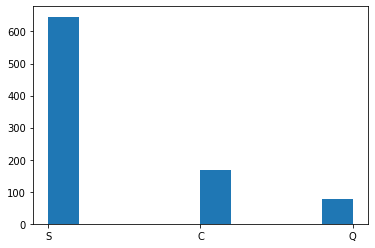

In [71]:
plt.hist(train_df["Embarked"])